In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

In [2]:
def listdir(path):
    ls = os.listdir(path)
    return [os.path.join(path, f) for f in ls]

def combine_data(path):
    dfs = list(map(pd.read_csv, listdir(path)))
    data = pd.concat(dfs)
    data.drop('Unnamed: 0', inplace=True, axis=1)
    return data

def get_results(path):
    data = combine_data(path)
    solved = data[data.solved == True]
    print(f"{len(solved)} solved out of {len(data)} = {np.average(data.solved)*100:.1f}%")
    print(f"Avg solve in {solved.time.mean():.1f} sec")
    print("Solved vs. ShootMe/Klondike-Solver")
    print(pd.DataFrame(solved.shootme.value_counts()))
    solved.visited.hist()
    return data

781 solved out of 10000 = 7.8%
Avg solve in 0.0 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min      760
Solved           21


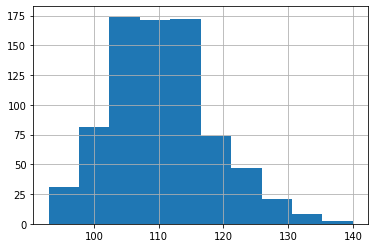

In [8]:
get_results('./bench/suite-10-greedyheuristic/');

3817 solved out of 10000 = 38.2%
Avg solve in 0.6 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min     3701
Solved          114
Unknown           2


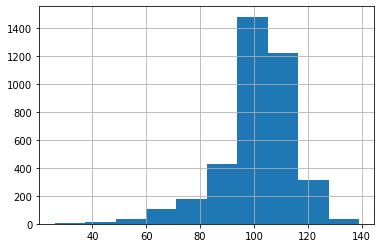

In [3]:
get_results("./bench/suite-10-rollout-0bb577bfe4/");

31 solved out of 70 = 44.3%
Avg solve in 5.5 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min       31


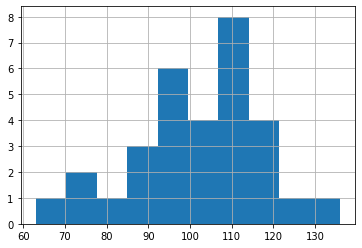

In [4]:
get_results("./bench/suite-10-rollout-k2-feeac68a81/");

847 solved out of 1700 = 49.8%
Avg solve in 30.0 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min      821
Solved           26


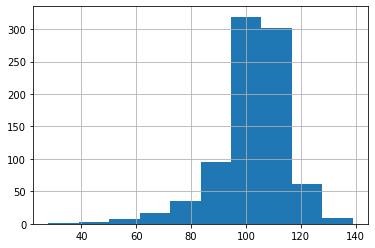

In [5]:
get_results("./bench/suite-10-rollout-k3-feeac68a81/");

58 solved out of 100 = 58.0%
Avg solve in 3.8 sec
Solved vs. ShootMe/Klondike-Solver
            shootme
Solved-Min       58


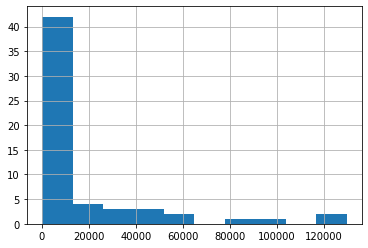

In [6]:
get_results('./bench/suite-10-backtracking/');